# synthetic time series for evaluation

In [1]:
# Created by Chengyu on 2021/1/17.
import matplotlib.pyplot as plt
import timesynth as ts
import numpy as np
import pandas as pd

In [2]:
# configuration
channel_num = 4
seg_num = 20
seg_len = 1000
state_num = 4
num_group = 10
num_ts_in_group = 10
save_path = '../data/synthetic_data/'

In [3]:
# Generate segment json
def generate_seg_json(seg_num, state_num, random_state=None):
    # Config seed to generate determinally.
    if random_state is not None:
        np.random.seed(random_state)
    seg_json = {}
    state_list = np.random.randint(state_num, size=seg_num)
    total_len = 1000
    for i, state in zip(range(seg_num), state_list):
        seg_len = 1000
        seg_json[total_len]=state
        total_len += seg_len
    return seg_json

In [4]:
from shape import RMDF
def gen_channel_from_json(seg_json):
    state_list = [seg_json[seg] for seg in seg_json]
    true_state_num = len(set(state_list))
    # This is an object list.
    rmdf_list = [RMDF.RMDF(depth=5) for i in range(true_state_num)]
    for rmdf in rmdf_list:
        rmdf.gen_anchor()
    seg_list = []
    for state in state_list:
        seg = [rmdf_list[state].gen(forking_depth=1, length=100) for i in range(5)]
        seg_list.append(np.concatenate(seg))
    result = np.concatenate(seg_list)
    return result

def gen_from_json(seg_json):
    # generate channel respectively.
    channel_list = [gen_channel_from_json(seg_json) for i in range(channel_num)]
    return np.stack(channel_list).T

In [5]:
seg_json_list = []
for i in range(num_group):
    seg_json =generate_seg_json(seg_num, state_num)
    while len(set([seg_json[key] for key in list(seg_json)])) != state_num:
        seg_json =generate_seg_json(seg_num, state_num)
    seg_json_list.append(seg_json)

## Generate data with shape-based states (Dataset 1)

In [6]:
def generate_group(num_ts_in_group, seg_json):
    data_list = []
    for i in range(num_ts_in_group):
        data = np.concatenate([gen_from_json(seg_json)])
        data_list.append(data)
    return data_list

group_list = [generate_group(num_ts_in_group, seg_json) for seg_json in seg_json_list]

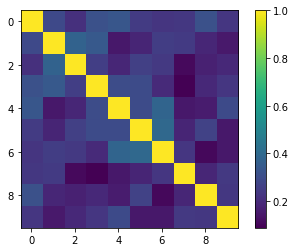

In [7]:
# from TSpy.label import seg_to_label
# from TSpy.metrics import calculate_NMI_matrix
# label_list = [seg_to_label(seg_json) for seg_json in seg_json_list]
# matrix = calculate_NMI_matrix(label_list)
# plt.imshow(matrix)
# plt.colorbar()
# plt.show()


In [8]:
width = num_ts_in_group * num_group
groundtruth_matrix = np.zeros(shape=(width, width))
for i in range(num_group):
    start = i*num_ts_in_group
    end = (i+1)*num_ts_in_group
    groundtruth_matrix[start:end, start:end] = 1
# plt.imshow(groundtruth_matrix)
# plt.show()

# Save Data

In [9]:
import os
dataset_name = 'dataset1'
full_path = save_path+dataset_name
if not os.path.exists(full_path):
    os.makedirs(full_path)
i = 0
for group in group_list:
    for data in group:
        df = pd.DataFrame(data).round(4)
        df.to_csv(full_path+'/test'+str(i)+'.csv', header=False)
        i += 1
np.save(save_path+'groundtruth_matrix_d1.npy', groundtruth_matrix)

## Generate data with statistical moment based states

In [10]:
# state_list = [seg_json[seg] for seg in seg_json]
# true_state_num = len(set(state_list))
# gaussian_param_list = np.arange(0.2,1,true_state_num)
# # print(gaussian_param_list)
# seg_list = []
# for state in gaussian_param_list:
#     seg_list.append(np.random.normal(0, state, size=1000))
# data = np.concatenate(seg_list)
# data_list.append(data)
# print(data_list[0].shape,data.shape)
# n_ts = 3

## Diaplay and save figures

In [11]:
# from TSpy.view import plot_mulvariate_time_series
# fig_path = 'dataset1_fig'
# full_path = save_path + fig_path
# if not os.path.exists(full_path):
#     os.makedirs(full_path)
# i = 0
# for group in group_list:
#     for data in group:
#         plot_mulvariate_time_series(data, save_path=full_path+'/test'+str(i)+'.png')
#         i += 1